In [ ]:
import simpy
import random
import numpy as np
import pandas as pd
import tqdm
import scipy.stats as st

# Section 6.1: Manufacturing Preparation Center (MPC)

In [ ]:
# Model Parameters
arrive_m = 8
Bmin = 5
Bmax = 15
Nstations = 3

# Simulation Parameters
SIM_TIME = 50 * 24 * 60     # Total simulation time in minutes (50 days)
WARMUP_TIME = 10 * 24 * 60  # Warm-up time in minutes (10 days)

# Statistics collections
data_enter_time = {}
data_iteration = {'ct': [], 'throughput': 0}
data_summary = {'ct': [], 'throughput': []}

def operator_process(env, operator):
    # Record entry time of item
    data_enter_time[operator] = env.now
    with operators.request() as req:
      yield req     # Request a station
      yield env.timeout(random.uniform(Bmin, Bmax))   # Processing time between Bmin and Bmax

    # Collect statistics after warmup
    if env.now > WARMUP_TIME:     # Start data collection after warm-up time
        data_iteration['ct'].append(env.now - data_enter_time[operator])   # Calculate cycle time
        data_iteration['throughput'] += 1    # Increment throughput count

def demand_generator(env,operators):
    """Randomly generate demand"""
    i = 0
    while True:
      yield env.timeout(random.expovariate(1/arrive_m))   # Time between arrivals follows an exponential distribution
      i += 1
      env.process(operator_process(env, f'Operator_process{i}'))   # Start a new operator process

for r in range(10):
    # Set random seed for reproducibility
    random.seed(r)  # To ensure that each iteration of the simulation uses a different but reproducible sequence of random numbers
    env = simpy.Environment()
    operators = simpy.Resource(env, capacity=Nstations) # Indicates the amount of stations that are available in the simulation
    env.process(demand_generator(env,operators))
    env.run(until=SIM_TIME)

    # Collect data from this iteration
    data_summary['ct'].append(np.mean(data_iteration['ct']))
    data_summary['throughput'].append(data_iteration['throughput'] / (SIM_TIME - WARMUP_TIME)) # Append normalized throughput to data summary
    # Clear the data
    data_iteration = {'ct': [], 'throughput': 0}
    data_enter_time = {}

# Summarize Results
print(f"Flow time: {np.mean(data_summary['ct'])} +/- {np.std(data_summary['ct'])} minutes")
print(f"Throughput: {np.mean(data_summary['throughput'])} +/- {np.std(data_summary['throughput'])} fixtures per minutes")
print(f"Range of mean throughput: [{np.min(data_summary['throughput'])}, {np.max(data_summary['throughput'])}]")

Flow time: 10.54609700402436 +/- 0.05779873212873436 minutes
Throughput: 0.1251423611111111 +/- 0.001168824476071666 fixtures per minutes
Range of mean throughput: [0.12295138888888889, 0.1267361111111111]


In [ ]:
# Model parameters
arrive = [1.0, 5.0, 10.0, 30.0, 45.0]  # Deterministic arrival times for this scenario
inter_arrival_times = [arrive[0]] + [arrive[i] - arrive[i-1] for i in range(1,len(arrive))]
Bmin = 5  # Minimum service time in minutes
Bmax = 15  # Maximum service time in minutes
bio_break_time = 3  # Duration of bio break in minutes
bio_break_inter_arrival_time = 20  # Time between bio breaks in minutes

# Item class definition
class Item:
    """Item attributes with name, processing time, and others (if needed)"""
    def __init__(self, name, arrival_time):
        self.name = name
        self.arrival_time = arrival_time
        self.service_time = (Bmin + Bmax) / 2  # Average service time

# Operator class definition
class Operator:
    """Operator attributes with state working, and others (if needed)"""
    def __init__(self, env):
        self.env = env
        self.busy = False   # Operator is initially not busy
        self.action = env.process(self.operator_bio_break())

    def operator_bio_break(self):
        while True:
            yield self.env.timeout(bio_break_inter_arrival_time)   # Wait until the next bio break
            print(f"Operator goes on a bio break at {self.env.now}")
            yield self.env.timeout(bio_break_time)                 # Duration of the bio break
            print(f"Operator returns from bio break at {self.env.now}")

# Demand generator process
def demand_generator(env, operators, inter_arrival_times):
    for i in range(len(inter_arrival_times)):
        yield env.timeout(inter_arrival_times[i])
        item = Item(f"Item{i+1}", env.now)   # Create a new item with arrival time
        print(f"{item.name} arrives at {env.now}")
        env.process(item_building_process(env, item, operators))

# Operator process to handle item building
def item_building_process(env, item, operators):
    with operators.request() as request:
        yield request         # Wait until an operator is available
        start_time = env.now  # Record the start time of the service
        print(f"{item.name} starts service at {start_time}")

        remaining_service_time = item.service_time
        while remaining_service_time > 0:
            bio_break_time_left = (bio_break_inter_arrival_time - (env.now % bio_break_inter_arrival_time)  # Time left until next bio break
            time_to_next_event = min(bio_break_time_left, remaining_service_time)  # Time until next event (bio break or service completion)
            yield env.timeout(time_to_next_event)         # Wait until the next event
            remaining_service_time -= time_to_next_event  # Reduce remaining service time

            if remaining_service_time > 0:
                print(f"{item.name} paused for bio break at {env.now}")
                yield env.timeout(bio_break_time)   # Wait for the duration of the bio break
                print(f"{item.name} resumes service at {env.now}")

        print(f"{item.name} completes service at {env.now}")

# Setup and run the simulation
env = simpy.Environment()
operators = simpy.Resource(env)
env.process(demand_generator(env, operators, inter_arrival_times))
env.run(until=max(arrive) + (Bmin + Bmax) / 2 + bio_break_time)  # Run until the last item is processed

Item1 arrives at 1.0
Item1 starts service at 1.0
Item2 arrives at 5.0
Item3 arrives at 10.0
Item1 completes service at 11.0
Item2 starts service at 11.0
Item2 paused for bio break at 20.0
Item2 resumes service at 23.0
Item2 completes service at 24.0
Item3 starts service at 24.0
Item4 arrives at 30.0
Item3 completes service at 34.0
Item4 starts service at 34.0
Item4 paused for bio break at 40.0
Item4 resumes service at 43.0
Item5 arrives at 45.0
Item4 completes service at 47.0
Item5 starts service at 47.0
Item5 completes service at 57.0


In [ ]:
# Model parameters
arrive = 0
inter_arrival_times = [1.0, 5.0, 10.0, 30.0, 45.0]  # Deterministic arrival times
Bmin = 10
Bmax = 20
shift_break_time = 5
shift_duration = 20
Btime = (Bmin + Bmax) / 2

class Item:
    """Item attributes with name and others (if needed)"""
    def __init__(self, name, arrival_time):
        self.name = name
        self.arrival_time = arrival_time
        self.processing_time = Btime

class Operator:
    """Operator attributes with state working and others (if needed)"""
    def __init__(self, env):
        self.env = env
        self.station = simpy.Resource(env, capacity=1)
        self.action = env.process(operator_schedule(env, self))

def demand_generator(env, operator):
    """
    Release items according to inter arrival times.
    Please print out the time stamp that an item arrives at the subsystem.
    """
    for i, arrival_time in enumerate(inter_arrival_times):
        yield env.timeout(arrival_time - env.now) # Wait until the next item's arrival time
        item = Item(f'Item{i+1}', env.now)        # Create a new item with current time as arrival time
        print(f"{item.name} arrives at {item.arrival_time} minutes")
        env.process(operator_process(env, item, operator))

def operator_process(env, item, operator):
    """
    Request usage of an operator.
    Please print out the time stamps for the operator's activities.
    """
    with operator.station.request() as req:
        yield req
        print(f"{item.name} starts processing at {env.now} minutes")
        yield env.timeout(item.processing_time)
        print(f"{item.name} finishes processing at {env.now} minutes")

def operator_schedule(env, operator):
    """
    Deal with operator shift schedule. Please print out the time stamps for the shift break.
    Please also print out if the operator can take a shift break or not. If yes, how long?
    """
    while True:
        yield env.timeout(shift_duration)
        if not operator.station.users:          # If no items are being processed
            print(f"Operator takes a shift break at {env.now} minutes")
            yield env.timeout(shift_break_time) # Wait for the duration of the shift break
            print(f"Operator returns from shift break at {env.now} minutes")
        else:
            print(f"Operator cannot take a break at {env.now} minutes")

# Set up the environment and run the simulation
env = simpy.Environment()
operator = Operator(env)
env.process(demand_generator(env, operator))
env.run(until=100)

Item1 arrives at 1.0 minutes
Item1 starts processing at 1.0 minutes
Item2 arrives at 5.0 minutes
Item3 arrives at 10.0 minutes
Item1 finishes processing at 16.0 minutes
Item2 starts processing at 16.0 minutes
Operator cannot take a break at 20 minutes
Item4 arrives at 30.0 minutes
Item2 finishes processing at 31.0 minutes
Item3 starts processing at 31.0 minutes
Operator cannot take a break at 40 minutes
Item5 arrives at 45.0 minutes
Item3 finishes processing at 46.0 minutes
Item4 starts processing at 46.0 minutes
Operator cannot take a break at 60 minutes
Item4 finishes processing at 61.0 minutes
Item5 starts processing at 61.0 minutes
Item5 finishes processing at 76.0 minutes
Operator takes a shift break at 80 minutes
Operator returns from shift break at 85 minutes


# Section 6.2: AGV Fleet

In [ ]:
# Model Parameters
arrive_v = 8 #mean of the interarrival time of new fixtures, which is exponentially distributed, so lambda = 1/8.
Vtime_min = 5 #transport time of an AGV, which is uniformly distributed[5,10] minutes
Vtime_max = 10 #transport time of an AGV, which is uniformly distributed[5,10] minutes
Nagvs = 2 #the number of AGVs

# Simulation Parameters
SIM_TIME = 50 * 24 * 60 #50 days, so this many minutes
WARMUP_TIME = 10 * 24 * 60 #10 days, so this many minutes

# Statistics collections
data_enter_time = {}
data_iteration = {'ct': [], 'throughput': 0}
data_summary = {'ct': [], 'throughput': []}


def agv_process(env, item):
    # Record entry time of item
    data_enter_time[item] = env.now
    req = agvs.request() #request access to resource machine
    yield req #wait for machine avaialble
    yield env.timeout(random.uniform(Vtime_min, Vtime_max)) # Generate transport task
    agvs.release(req) #release the job

    # Collect statistics after warmup
    if env.now > WARMUP_TIME:  # Start data collection after warm-up time
      data_iteration['ct'].append(env.now - data_enter_time[item])
      data_iteration['throughput'] = data_iteration['throughput'] + 1

def demand_generator(env):
    """Randomly generate demand"""
    i = 1
    while True:
      yield env.timeout(random.expovariate(1 / arrive_v)) #interarrival time, which is exponentially ditributed with lambda = 1/8.
      i += 1
      env.process(agv_process(env, f'Item {i}')) #start job processing

for r in range(10):
    # Set random seed for reproducibility
    random.seed(r)
    env = simpy.Environment()
    agvs = simpy.Resource(env, Nagvs)
    env.process(demand_generator(env))

    env.run(until=SIM_TIME)

    # Collect data from this iteration
    data_summary['ct'].append(np.mean(data_iteration['ct']))
    data_summary['throughput'].append(data_iteration['throughput'] / (SIM_TIME - WARMUP_TIME))
    # Clear the data
    data_iteration = {'ct': [], 'throughput': 0}
    data_enter_time = {}


# Summarize Results
print(f"Flow time: {np.mean(data_summary['ct'])} +/- {np.std(data_summary['ct'])} minutes")
print(f"Throughput: {np.mean(data_summary['throughput'])} +/- {np.std(data_summary['throughput'])} fixtures per minutes")
print(f"Range of mean throughput: [{np.min(data_summary['throughput'])}, {np.max(data_summary['throughput'])}]")

Flow time: 8.656677689322738 +/- 0.07477561525291325 minutes
Throughput: 0.12538194444444445 +/- 0.001309538840702571 fixtures per minutes
Range of mean throughput: [0.12270833333333334, 0.12690972222222222]


In [ ]:
import simpy

# Model Parameters
arrive = [1.0, 3.0, 5.0, 7.0, 10.0]  #arrival times of items in minutes
inter_arrival_times = [arrive[0]] + [arrive[i] - arrive[i-1] for i in range(1, len(arrive))] #compute list of interarrival times starting from t=0
Nagvs = 2 #number of AGVs
Vspeed = 1 * 60 #the vehicle speed is 1 m/s, so 60 m/min
distance = 180 #the distance between the joint buffer and the loading dock

class Item:
    def __init__(self, name, source, destination):
        """Item attributes with name, source, and destination"""
        self.name = name
        self.source = source
        self.destination = destination

class AGV:
    def __init__(self):
        """AGV attributes with location, destination, and others (if needed)"""
        self.location = 'MPC'
        self.destination = 'loading dock'
        self.assigned_distance = 0
        self.workload = simpy.Container(env)
        self.resource = simpy.Resource(env, capacity=1)

def demand_generator(env, inter_arrival_times, agvs, distance, Vspeed):
    """
    Release items according to inter arrival times.
    Print out the time stamp that an item arrives at the subsystem.
    """
    for i, inter_arrival_time in enumerate(inter_arrival_times): #for each item seperately
        yield env.timeout(inter_arrival_time) #wait for the item to arrive
        print(f"Item {i+1} arrives at time {env.now}") #print the arrival time of the item
        env.process(agv_process(env, i+1, agvs, distance, Vspeed)) #for each item, start the agv_process seperately

def agv_process(env, item_id, agvs, distance, Vspeed):
    """
    Schedule the selected AGV to transport a new fixture from joint buffer to loading dock.
    Print out the total distance of the selected AGV's all assigned tasks.
    Print out the time stamps for the AGV's activities.
    """
    agv_id = agv_selection(agvs) #returns id of agvs with the least workload, so agv is coupled to an item
    print(f'AGV {agv_id + 1} is scheduled to transport Item {item_id}') #print which agv is scheduled to transport the item

    # Determine selected AGV's total travel distance for all its assigned tasks
    yield agvs[agv_id].workload.put(distance) #increase workload of selected agv with the transport of the particular item
    agvs[agv_id].assigned_distance += distance #increase the total assigned distance of the agv (including all item tasks)
    print(f'Total distance of the selected AGV\'s assigned tasks: {agvs[agv_id].assigned_distance} meter')

    # AGV activities and locations
    with agvs[agv_id].resource.request() as req:
        yield req  #request availability of an agv
        yield agvs[agv_id].workload.put(distance)  #add the distance on 180 as soon as the transportation starts to account for driving back to the MPC
        #in case agv is not located at the MPC, it rides to the MPC
        if agvs[agv_id].location == 'loading dock':
            print(f'AGV {agv_id + 1} starts travelling back to the MPC at {env.now}') #when agv is at loading dock, then it starts getting back to the MPC
            for _ in range(int(distance / Vspeed)): #this needs to run a distance/Vspeed amount of times
                yield agvs[agv_id].workload.get(Vspeed) #for every minute the agv rides, the workload decreases with 60 meters
                yield env.timeout(1)  #wait 1 second, to account 'for every minute' above
            print(f'AGV {agv_id + 1} is back at the MPC at {env.now}')
            agvs[agv_id].location = 'MPC'#update location of agv, as it is back at MPC after 3 minutes of starting to come back from the joint buffer

        #when agv is located at the MPC, it starts transporting immediately
        print(f'AGV {agv_id + 1} begins with transport of Item {item_id} at {env.now}')
        for _ in range(int(distance / Vspeed)):
            yield agvs[agv_id].workload.get(Vspeed) #the workload once again decreases with 1 m/s (just like above)
            yield env.timeout(1) #so, go from MPC to loading dock
        print(f'Item {item_id} is delivered to loading dock at {env.now}')
        agvs[agv_id].location = 'loading dock' #now agv is located at loading dock
        agvs[agv_id].assigned_distance -= distance #so, assigned distance to agv is now 180 m less

def agv_selection(agvs):
    """
    Used to select the least workload AGV.
    Print out the workload of each AGV for the selection.
    """
    min_workload = float('inf') #first, set minimum workload to infinity
    selected_agv_id = None #placeholder variable
    for i, agv in enumerate(agvs): #for each agv's index
        print(f'AGV {i + 1} has a workload of {agv.workload.level} meter') #print the workload
        if agv.workload.level < min_workload: #update the minimum agv workload if it the workload of the current agv is smaller than the current minimum agv workload
            min_workload = agv.workload.level
            selected_agv_id = i
    return selected_agv_id

# Initialize the environment
env = simpy.Environment()
agvs = [AGV() for _ in range(Nagvs)]

# Start the process and run the environment
env.process(demand_generator(env, inter_arrival_times, agvs, distance, Vspeed))
env.run()


Item 1 arrives at time 1.0
AGV 1 has a workload of 0 meter
AGV 2 has a workload of 0 meter
AGV 1 is scheduled to transport Item 1
Total distance of the selected AGV's assigned tasks: 180 meter
AGV 1 begins with transport of Item 1 at 1.0
Item 2 arrives at time 3.0
AGV 1 has a workload of 240 meter
AGV 2 has a workload of 0 meter
AGV 2 is scheduled to transport Item 2
Total distance of the selected AGV's assigned tasks: 180 meter
AGV 2 begins with transport of Item 2 at 3.0
Item 1 is delivered to loading dock at 4.0
Item 3 arrives at time 5.0
AGV 1 has a workload of 180 meter
AGV 2 has a workload of 240 meter
AGV 1 is scheduled to transport Item 3
Total distance of the selected AGV's assigned tasks: 180 meter
AGV 1 starts travelling back to the MPC at 5.0
Item 2 is delivered to loading dock at 6.0
Item 4 arrives at time 7.0
AGV 1 has a workload of 420 meter
AGV 2 has a workload of 180 meter
AGV 2 is scheduled to transport Item 4
Total distance of the selected AGV's assigned tasks: 180 m

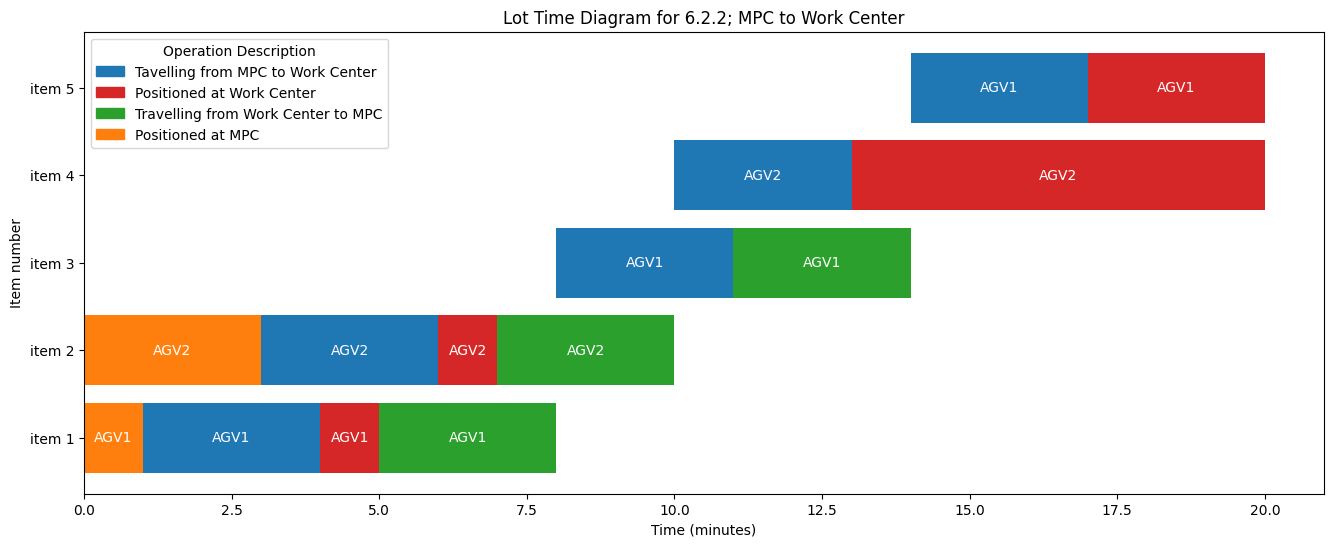

In [ ]:
#Code for lot time diagram
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Sample data for lot_time; replace with your actual data
lot_time = [
    ['item 1', 3, 1, 0, 'tab:blue'], #blue is travel from MPC to Work Center
    ['item 2', 3, 3, 1, 'tab:blue'],
    ['item 3', 3, 8, 0, 'tab:blue'],
    ['item 4', 3, 10, 1, 'tab:blue'],
    ['item 5', 3, 14, 0, 'tab:blue'],
    ['item 1', 1, 4, 0, 'tab:red'], #red is agv being positioned at Work Center
    ['item 1', 3, 5, 0, 'tab:green'], #green is travel from Work Center back to MPC
    ['item 2', 1, 6, 1, 'tab:red'],
    ['item 2', 3, 7, 1, 'tab:green'],
    ['item 3', 3, 11, 0, 'tab:green'],
    ['item 4', 7, 13, 1, 'tab:red'],
    ['item 5', 3, 17, 0, 'tab:red'],
    ['item 2', 3, 0, 1, 'tab:orange'],
    ['item 1', 1, 0, 0, 'tab:orange'] #yellow is agv being positioned at MPC
]

# Convert lot_time to a DataFrame
df = pd.DataFrame(lot_time, columns=['Name', 'ProcessingTime', 'StartTime', 'id', 'color'])

# Plotting the lot time diagram
fig, ax = plt.subplots(1, figsize=(16, 6))

# Create a horizontal bar chart
ax.barh(df.Name, df.ProcessingTime, left=df.StartTime, color=df.color)

# Annotate each bar with the machine ID
for j, p, s, i in zip(df.Name, df.ProcessingTime, df.StartTime, df.id):
    ax.text(s + p / 2, j, f'AGV{i+1}', ha='center', va='center', color='white')

# Create legend handles
legend_handles = [
    Patch(color='tab:blue', label='Tavelling from MPC to Work Center'),
    Patch(color='tab:red', label='Positioned at Work Center'),
    Patch(color='tab:green', label='Travelling from Work Center to MPC'),
    Patch(color='tab:orange', label='Positioned at MPC')
]

# Add legend to the plot
ax.legend(handles=legend_handles, title='Operation Description')

# Set labels and title
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Item number')
ax.set_title('Lot Time Diagram for 6.2.2; MPC to Work Center')

# Show the plot
plt.show()

In [ ]:

# Model parameters
arrive = [1.0, 5.0, 10.0, 30.0, 45.0]
inter_arrival_times = [arrive[0]] + [arrive[i] - arrive[i-1] for i in range(1, len(arrive))]
Vspeed = 1  # AGV speed in m/s
Vdr = 0.1 / 100  # Discharge rate per meter
Vcr = 10 / 100  # Charge rate per minute
Vct = 50 / 100  # Critical threshold
distance = 180  # Distance between joint buffer and loading dock in meters
charge_distance = 120  # Distance to charging station in meters

class Item:
    def __init__(self, name, source, destination):
        """Item attributes with name, source, and destination"""
        self.name = name
        self.source = source
        self.destination = destination

class AGV:
    def __init__(self, env, name, location):
        """AGV attributes with location, destination, and others (if needed)"""
        self.env = env
        self.name = name
        self.location = location
        self.battery = 100  # Initial battery level
        self.resource = simpy.Resource(env, capacity=1)

def agv_charging(env, agv):
    """
    AGV charging activities.
    Please print out the amount of charge, and time stamps for the AGV's activities.
    """
    # Trip to the charging station
    print(f'{env.now}: {agv.name} starts driving to the charging station.')
    travel_time = charge_distance / (Vspeed * 60)
    battery_usage = charge_distance * Vdr * 100
    agv.battery -= battery_usage
    yield env.timeout(travel_time)
    print(f'{env.now}: {agv.name} arrived at the charging station. Battery level: {agv.battery}%')

    # Charging process
    print(f'{env.now}: {agv.name} started charging.')
    while agv.battery < 100:
        yield env.timeout(1)
        agv.battery += Vcr * 100
        if agv.battery > 100:
            agv.battery = 100
        print(f'{env.now}: {agv.name} charging... battery level at {agv.battery}%')
    print(f'{env.now}: {agv.name} fully charged.')

    # Trip back from the charging station
    print(f'{env.now}: {agv.name} starts driving back from the charging station.')
    agv.battery -= battery_usage
    yield env.timeout(travel_time)
    print(f'{env.now}: {agv.name} returned from the charging station. Battery level: {agv.battery}%')

def agv_battery_control(env, agv):
    """
    Check the AGV's battery level and send it to charge if necessary.
    """
    if agv.battery < Vct * 100:
        print(f'{env.now}: {agv.name} battery low ({agv.battery}%), requesting charge.')
        yield env.process(agv_charging(env, agv))

def demand_generator(env, inter_arrival_times, agv):
    """
    Release items according to inter arrival times.
    Please print out the time stamp that an item arrives at the subsystem.
    """
    item_count = 0
    while item_count < len(inter_arrival_times):
        yield env.timeout(inter_arrival_times[item_count])
        item = Item(f'Item{item_count + 1}', 'MPC', 'WorkCenter')
        print(f'{env.now}: {item.name} arrives at MPC.')
        env.process(agv_process(env, agv, item))
        item_count += 1

def agv_process(env, agv, item):
    """Request usage of an AGV for transport"""
    with agv.resource.request() as request:
        yield request
        yield env.process(agv_driving(env, agv, item))

def agv_driving(env, agv, item):
    """
    AGV traveling activities and locations.
    Please print out item information, battery level, and time stamps for the AGV's activities.
    """
    yield env.process(agv_battery_control(env, agv))

    # Loaded trip from MPC to WorkCenter
    print(f'{env.now}: {agv.name} starts driving from {item.source} to {item.destination} with {item.name}.')
    travel_time = distance / (Vspeed * 60)
    battery_usage = distance * Vdr * 100

    agv.battery -= battery_usage
    yield env.timeout(travel_time)
    agv.location = item.destination
    print(f'{env.now}: {agv.name} delivered {item.name} to {item.destination}. Battery level: {agv.battery}%')

    # Unloaded trip back to MPC
    print(f'{env.now}: {agv.name} starts driving back to MPC.')
    agv.battery -= battery_usage
    yield env.timeout(travel_time)

    agv.location = item.source
    print(f'{env.now}: {agv.name} returned to MPC. Battery level: {agv.battery}%')

    yield env.process(agv_battery_control(env, agv))

# Initialize simulation environment
env = simpy.Environment()
agv = AGV(env, 'AGV_1', 'MPC')
env.process(demand_generator(env, inter_arrival_times, agv))
env.run()

1.0: Item1 arrives at MPC.
1.0: AGV_1 starts driving from MPC to WorkCenter with Item1.
4.0: AGV_1 delivered Item1 to WorkCenter. Battery level: 82.0%
4.0: AGV_1 starts driving back to MPC.
5.0: Item2 arrives at MPC.
7.0: AGV_1 returned to MPC. Battery level: 64.0%
7.0: AGV_1 starts driving from MPC to WorkCenter with Item2.
10.0: Item3 arrives at MPC.
10.0: AGV_1 delivered Item2 to WorkCenter. Battery level: 46.0%
10.0: AGV_1 starts driving back to MPC.
13.0: AGV_1 returned to MPC. Battery level: 28.0%
13.0: AGV_1 battery low (28.0%), requesting charge.
13.0: AGV_1 starts driving to the charging station.
15.0: AGV_1 arrived at the charging station. Battery level: 16.0%
15.0: AGV_1 started charging.
16.0: AGV_1 charging... battery level at 26.0%
17.0: AGV_1 charging... battery level at 36.0%
18.0: AGV_1 charging... battery level at 46.0%
19.0: AGV_1 charging... battery level at 56.0%
20.0: AGV_1 charging... battery level at 66.0%
21.0: AGV_1 charging... battery level at 76.0%
22.0: AGV

## Section 6.3: Work Center

In [ ]:
# Model Parameters
arrive_w = 4
Rtime_min = 1
Rtime_max = 3
Nrobots = 1

# Simulation Parameters
SIM_TIME = 50 * 24 * 60
WARMUP_TIME = 10 * 24 * 60

# Statistics collections
data_enter_time = {}
data_iteration = {'ct': [], 'throughput': 0}
data_summary = {'ct': [], 'throughput': []}

def robot_process(env, robot):
    # Record entry time of item
    data_enter_time[robot] = env.now
    yield env.timeout(random.uniform(Rtime_min, Rtime_max))
    # Collect statistics after warmup
    if env.now > WARMUP_TIME:  # Start data collection after warm-up time
        data_iteration['ct'].append(env.now - data_enter_time[robot])
        data_iteration['throughput'] += 1

def demand_generator(env):
    """Randomly generate demand"""
    while True:
        # Generate fixture arrivals
        yield env.timeout(random.expovariate(1/arrive_w))

        # Spawn a robot to handle the fixture
        env.process(robot_process(env, 'Robot_'+str(env.now)))

for r in range(10):
    # Set random seed for reproducibility
    random.seed(r)
    # Initialize simulation environment
    env = simpy.Environment()
    # Start demand generator
    env.process(demand_generator(env))
    # Run simulation
    env.run(until=SIM_TIME)
    # Collect data from this iteration
    data_summary['ct'].append(np.mean(data_iteration['ct']))
    data_summary['throughput'].append(data_iteration['throughput'] / (SIM_TIME - WARMUP_TIME))
    # Clear the data
    data_iteration = {'ct': [], 'throughput': 0}
    data_enter_time = {}

# Summarize Results
print(f"Flow time: {np.mean(data_summary['ct'])} +/- {np.std(data_summary['ct'])} minutes")
print(f"Throughput: {np.mean(data_summary['throughput'])} +/- {np.std(data_summary['throughput'])} fixtures per minute")
print(f"Range of mean throughput: [{np.min(data_summary['throughput'])}, {np.max(data_summary['throughput'])}]")

Flow time: 2.0000703790297463 +/- 0.005139071851481599 minutes
Throughput: 0.250703125 +/- 0.0016552569888893284 fixtures per minute
Range of mean throughput: [0.24836805555555555, 0.25418402777777777]


In [ ]:
# Model parameters
arrive = [1.0, 5.0, 10.0, 15.0, 30.0]
inter_arrival_times = [arrive[i] - arrive[i-1] for i in range(1, len(arrive))]
inter_arrival_times.insert(0, arrive[0])
Nmachines = 4
Nistore = 2
Ptime = 20
Rtime = 1

class Item:
    """Item attributes with name and others (if needed)"""
    def __init__(self, name, arrivaltime):
        self.name = name
        self.arrivaltime = arrivaltime

def demand_generator(env, inter_arrival_times, items, robot, buffers):
    """
    Release items according to inter arrival times.
    Please print out the time stamp that an item arrives at the subsystem.
    """
    for i, ia in enumerate(inter_arrival_times):
        yield env.timeout(ia)
        item = Item(f"Item_{i+1}", env.now)
        items.append(item)
        print(f"Item {item.name} arrives at {env.now}")
        env.process(dock_to_buffer_robot_process(env, item, robot, buffers))

def dock_to_buffer_robot_process(env, item, robot, buffers):
    """
    Schedule the robot to move a new fixture to the selected internal buffer.
    Please print out item and buffer information, and time stamps for the robot's activities.
    """
    with robot.request() as req:
        yield req
        print(f"Robot starts moving {item.name} at {env.now}")
        yield env.timeout(Rtime)
        print(f"Robot finishes moving {item.name} at {env.now}")
        selectedbuffer = buffer_selection(buffers)
        yield buffers[selectedbuffer].put(item)
        env.process(machine_process(env, item, buffers[selectedbuffer]))

def machine_process(env, item, buffer):
    """
    Schedule the machines to process new fixtures.
    Please print out item information, and the time stamps for the machine's activities.
    """
    with machines.request() as req:
        yield req
        item = yield buffer.get()
        print(f"Machine starts processing {item.name} at {env.now}")
        yield env.timeout(Ptime)
        print(f"Machine finishes processing {item.name} at {env.now}")

def buffer_selection(buffers):
    """Used to select the buffer with the least WIP"""
    # Store WIP for selecting buffer
    current_WIP = [len(buffer.items) for buffer in buffers]
    # Select buffer
    internal_buffer_select = current_WIP.index(min(current_WIP))
    return internal_buffer_select

env = simpy.Environment()
robot = simpy.Resource(env, capacity=1)
machines = simpy.Resource(env, capacity=Nmachines)
buffers = [simpy.Store(env) for _ in range(Nmachines)]
items = []

# Start the processes and run the environment
env.process(demand_generator(env, inter_arrival_times, items, robot, buffers))
env.run()

Item Item_1 arrives at 1.0
Robot starts moving Item_1 at 1.0
Robot finishes moving Item_1 at 2.0
Machine starts processing Item_1 at 2.0
Item Item_2 arrives at 5.0
Robot starts moving Item_2 at 5.0
Robot finishes moving Item_2 at 6.0
Machine starts processing Item_2 at 6.0
Item Item_3 arrives at 10.0
Robot starts moving Item_3 at 10.0
Robot finishes moving Item_3 at 11.0
Machine starts processing Item_3 at 11.0
Item Item_4 arrives at 15.0
Robot starts moving Item_4 at 15.0
Robot finishes moving Item_4 at 16.0
Machine starts processing Item_4 at 16.0
Machine finishes processing Item_1 at 22.0
Machine finishes processing Item_2 at 26.0
Item Item_5 arrives at 30.0
Robot starts moving Item_5 at 30.0
Machine finishes processing Item_3 at 31.0
Robot finishes moving Item_5 at 31.0
Machine starts processing Item_5 at 31.0
Machine finishes processing Item_4 at 36.0
Machine finishes processing Item_5 at 51.0


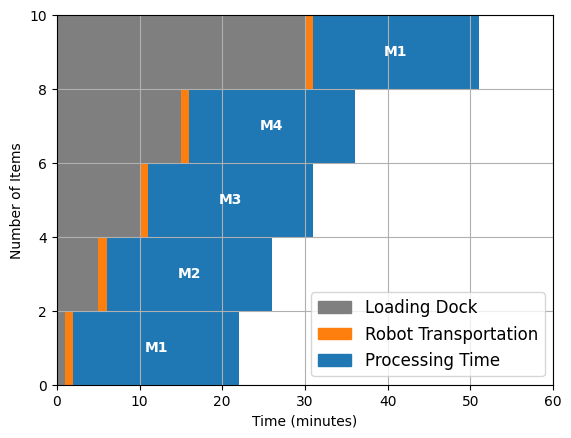

In [ ]:
items = ['M1', 'M2', 'M3', 'M4', 'M1']
arrival_times = [1.0, 5.0, 10.0, 15.0, 30.0]
docktime = [1.0, 5.0, 10.0, 15.0, 30.0]
duracion_robot = 1.0
duracion_procesamiento = 20.0

fig, gnt = plt.subplots()

gnt.set_ylim(0, 10)
gnt.set_xlim(0, 60)
gnt.set_xlabel('Time (minutes)')
gnt.set_ylabel('Number of Items')

gnt.grid(True)

for i, item in enumerate(items):
    gnt.broken_barh([(0, docktime[i])], (i * 2, 2), facecolors='tab:gray')
    gnt.broken_barh([(arrival_times[i], duracion_robot)], (i * 2, 2), facecolors='tab:orange')
    gnt.broken_barh([(arrival_times[i] + duracion_robot, duracion_procesamiento)], (i * 2, 2), facecolors='tab:blue')

for i, item in enumerate(items):
    gnt.text(arrival_times[i] + duracion_robot + duracion_procesamiento / 2, i * 2 + 1, item, ha='center', va='center', color='white', weight='bold')

from matplotlib.patches import Patch
legend_labels = ['Loading Dock', 'Robot Transportation', 'Processing Time']
legend_colors = ['tab:gray', 'tab:orange', 'tab:blue']
patches = [Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=patches, loc='lower right', fontsize=12)

plt.show()


In [ ]:

# Model parameters
arrive = [1.0, 5.0, 10.0, 15.0, 30.0]
inter_arrival_times = [arrive[i] - arrive[i-1] for i in range(1, len(arrive))]
inter_arrival_times.insert(0, arrive[0])
Nmachines = 4
Nistore = 2
Ptime = 20
Rtime = 1

class Item:
    """Item attributes with name and others (if needed)"""
    def __init__(self, name, arrivaltime):
        self.name = name
        self.arrivaltime = arrivaltime
        self.finished = False

def demand_generator(env, inter_arrival_times, items, robot, buffers):
    """
    Release items according to inter arrival times.
    Print out the time stamp that an item arrives at the subsystem.
    """
    for i, ia in enumerate(inter_arrival_times):
        yield env.timeout(ia)
        item = Item(f"Item_{i+1}", env.now)
        items.append(item)
        print(f"Item {item.name} arrives at {env.now}")
        env.process(dock_to_buffer_robot_process(env, item, robot, buffers))

def dock_to_buffer_robot_process(env, item, robot, buffers):
    """
    Schedule the robot to move a new fixture to the selected internal buffer.
    Print out item and buffer information, and time stamps for the robot's activities.
    """
    with robot.request() as req:
        yield req
        print(f"Robot starts moving {item.name} to buffer at {env.now}")
        yield env.timeout(Rtime)
        selectedbuffer = buffer_selection(buffers)
        yield buffers[selectedbuffer].put(item)
        print(f"Robot finishes moving {item.name} to buffer {selectedbuffer} at {env.now}")
        env.process(machine_process(env, item, buffers[selectedbuffer]))

def buffer_to_dock_robot_process(env, item, robot):
    """
    Schedule the robot to move a finished fixture from an internal buffer to loading dock.
    Print out item and buffer information, and time stamps for the robot's activities.
    """
    with robot.request() as req:
        yield req
        if item.finished == True:
            print(f"Robot starts moving {item.name} to dock at {env.now}")
            yield env.timeout(Rtime)
            print(f"Robot finishes moving {item.name} to dock at {env.now}")

def machine_process(env, item, buffer):
    """
    Schedule the machines to process new fixtures.
    Print out item information, and the time stamps for the machine's activities.
    """
    with machines.request() as req:
        yield req
        item = yield buffer.get()
        print(f"Machine starts processing {item.name} at {env.now}")
        yield env.timeout(Ptime)
        item.finished = True
        print(f"Machine finishes processing {item.name} at {env.now}")
        env.process(buffer_to_dock_robot_process(env, item, robot))


def buffer_selection(buffers):
    """Used to select the buffer with the least WIP"""
    current_WIP = [len(buffer.items) for buffer in buffers]
    internal_buffer_select = current_WIP.index(min(current_WIP))
    return internal_buffer_select

env = simpy.Environment()
robot = simpy.Resource(env, capacity=1)
machines = simpy.Resource(env, capacity=Nmachines)
buffers = [simpy.Store(env) for _ in range(Nmachines)]
items = []
env.process(demand_generator(env, inter_arrival_times, items, robot, buffers))
env.run()


Item Item_1 arrives at 1.0
Robot starts moving Item_1 to buffer at 1.0
Robot finishes moving Item_1 to buffer 0 at 2.0
Machine starts processing Item_1 at 2.0
Item Item_2 arrives at 5.0
Robot starts moving Item_2 to buffer at 5.0
Robot finishes moving Item_2 to buffer 0 at 6.0
Machine starts processing Item_2 at 6.0
Item Item_3 arrives at 10.0
Robot starts moving Item_3 to buffer at 10.0
Robot finishes moving Item_3 to buffer 0 at 11.0
Machine starts processing Item_3 at 11.0
Item Item_4 arrives at 15.0
Robot starts moving Item_4 to buffer at 15.0
Robot finishes moving Item_4 to buffer 0 at 16.0
Machine starts processing Item_4 at 16.0
Machine finishes processing Item_1 at 22.0
Robot starts moving Item_1 to dock at 22.0
Robot finishes moving Item_1 to dock at 23.0
Machine finishes processing Item_2 at 26.0
Robot starts moving Item_2 to dock at 26.0
Robot finishes moving Item_2 to dock at 27.0
Item Item_5 arrives at 30.0
Robot starts moving Item_5 to buffer at 30.0
Machine finishes proc

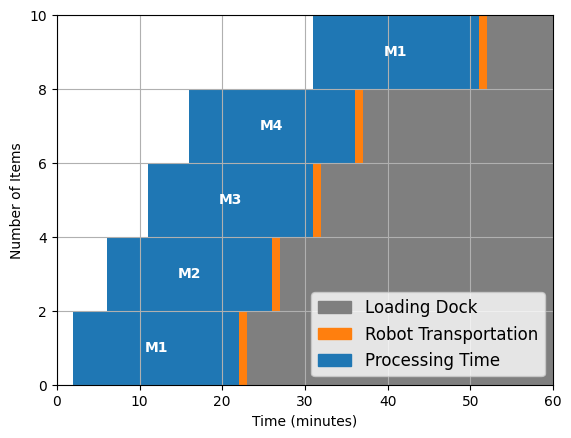

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

items = ['M1', 'M2', 'M3', 'M4', 'M1']
tiempos_llegada = [1.0, 5.0, 10.0, 15.0, 30.0]
docktime = [1.0, 5.0, 10.0, 15.0, 30.0]
duracion_robot = 1.0
duracion_procesamiento = 20.0

fig, gnt = plt.subplots()

gnt.set_ylim(0, 10)
gnt.set_xlim(0, 60)
gnt.set_xlabel('Time (minutes)')
gnt.set_ylabel('Number of Items')

gnt.grid(True)

for i, item in enumerate(items):
    gnt.broken_barh([(tiempos_llegada[i] + duracion_robot, duracion_procesamiento + 1)], (i * 2, 2), facecolors='tab:blue')
    gnt.broken_barh([(docktime[i] + duracion_procesamiento + 1, 60)], (i * 2, 2), facecolors='tab:gray')
    gnt.broken_barh([(tiempos_llegada[i] + duracion_procesamiento + 1, duracion_robot)], (i * 2, 2), facecolors='tab:orange')

for i, item in enumerate(items):
    gnt.text(tiempos_llegada[i] + duracion_robot + duracion_procesamiento / 2, i * 2 + 1, item, ha='center', va='center', color='white', weight='bold')

legend_labels = ['Loading Dock', 'Robot Transportation', 'Processing Time']
legend_colors = ['tab:gray', 'tab:orange', 'tab:blue']
patches = [Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=patches, loc='lower right', fontsize=12)

plt.show()


# Section 6.4: System Integration

In [ ]:
# Model parameters
arrive_m = 10
Nmachines = 4
Pmin = 20
Pmax = 40
Rtime = 1
Njstore = 20  # Capacity Joint Buffer
Nistore = 8  # Capacity Internal Buffer
Nstations = 2
Bmin = 5
Bmax = 15
Dtime = 5
Nagvs = 2
Vspeed = 1 * 60  # Changed to meters / minute
distance = 180

# Simulation parameters
SIM_TIME = 50 * 24 * 60
WARMUP_TIME = 10 * 24 * 60

# Statistics Collections
data_summary = {"ct": [], "throughput": []}

# Create class for collection of data
class DataCollection:
    """Data collection class to keep track of item entry time, flow time, and throughput"""
    def __init__(self):
        self.data_entry_time = {}
        self.data_iteration = {"ct": [], "throughput": 0}

class Item:
    """Item attributes with name and others (if needed)"""
    def __init__(self, name, number):
        self.name = name
        self.number = number
        self.finished = False

class AGV:
    """AGV attributes with location, destination, and others (if needed)"""
    def __init__(self, name, location, destination, item_id):
        self.name = name
        self.location = location
        self.destination = destination
        self.item_id = item_id
        self.resource = simpy.Resource(env, capacity=1)
        self.workload = simpy.Container(env)
        self.assigned_distance = 0  # Added attribute

def demand_generator(env, operators, ibuffer):
    """Randomly generate demand"""
    i = 0
    while True:
        yield env.timeout(random.expovariate(1 / arrive_m))
        item = Item(f'Item {i}', env.now)
        yield ibuffer.put(item)
        i += 1
        env.process(item_building_process(env, item, operators, ibuffer))

def item_building_process(env, item, operators, ibuffer):
    """Item arrives, is built into fixture by an operator"""
    with operators.request() as req:
        yield req
        yield ibuffer.get()  # Wait for an operator to be free
        yield env.timeout(random.uniform(Bmin, Bmax))
        yield ibuffer.put(item)
        env.process(agv_transport_joint_buffer_to_dock(env, item, agvs))

def agv_transport_joint_buffer_to_dock(env, item, agvs):
    """Schedule an AGV to transport a new fixture to loading dock"""
    agv_id = agv_selection(agvs)
    agvs[agv_id].assigned_distance += distance
    with agvs[agv_id].resource.request() as req:
        yield req
        if agvs[agv_id].location == 'MPC':
            yield agvs[agv_id].workload.put(distance)
            for _ in range(int(distance / Vspeed)):
                yield agvs[agv_id].workload.get(Vspeed)
                yield env.timeout(1)
            agvs[agv_id].location = 'loading dock'
            agvs[agv_id].assigned_distance -= distance
        else:
            yield agvs[agv_id].workload.put(2 * distance)
            for _ in range(int(distance / Vspeed)):
                yield agvs[agv_id].workload.get(Vspeed)
                yield env.timeout(1)
            agvs[agv_id].location = 'MPC'
            for _ in range(int(distance / Vspeed)):
                yield agvs[agv_id].workload.get(Vspeed)
                yield env.timeout(1)
            agvs[agv_id].location = 'loading dock'
            agvs[agv_id].assigned_distance -= distance
    env.process(dock_to_buffer_robot_process(env, item, robot, buffers))

def dock_to_buffer_robot_process(env, item, robot, buffers):
    """Schedule the robot to move a new fixture to an internal buffer"""
    with robot.request() as req:
        yield req
        yield env.timeout(Rtime)
        selectedbuffer = buffer_selection(buffers)
        yield buffers[selectedbuffer].put(item)
        env.process(machine_process(env, item, buffers[selectedbuffer]))

def machine_process(env, item, buffer):
    """Schedule the machines to process new fixtures"""
    with machines.request() as req:
        yield req
        item = yield buffer.get()
        yield env.timeout(random.uniform(Pmin, Pmax))
        item.finished = True
        env.process(buffer_to_dock_robot_process(env, item, robot, buffers))

def buffer_to_dock_robot_process(env, item, robot, buffers):
    """Schedule the robot to move a finished fixture to the loading dock"""
    with robot.request() as req:
        yield req
        if item.finished:
            yield env.timeout(Rtime)
            env.process(agv_transport_dock_to_joint_buffer(env, item, agvs))

def agv_transport_dock_to_joint_buffer(env, item, agvs):
    """Schedule an AGV to transport a finished fixture to joint buffer"""
    agv_id = agv_selection(agvs)
    agvs[agv_id].assigned_distance += distance
    with agvs[agv_id].resource.request() as req:
        yield req
        if agvs[agv_id].location == 'loading dock':
            yield agvs[agv_id].workload.put(distance)
            for _ in range(int(distance / Vspeed)):
                yield agvs[agv_id].workload.get(Vspeed)
                yield env.timeout(1)
            agvs[agv_id].location = 'MPC'
            agvs[agv_id].assigned_distance -= distance
        else:
            yield agvs[agv_id].workload.put(2 * distance)
            for _ in range(int(distance / Vspeed)):
                yield agvs[agv_id].workload.get(Vspeed)
                yield env.timeout(1)
            agvs[agv_id].location = 'loading dock'
            for _ in range(int(distance / Vspeed)):
                yield agvs[agv_id].workload.get(Vspeed)
                yield env.timeout(1)
            agvs[agv_id].location = 'MPC'
            agvs[agv_id].assigned_distance -= distance
    env.process(item_detaching_process(env, item, ibuffer))

def item_detaching_process(env, item, ibuffer):
    """Finished fixtures are detached by an operator"""
    with operators.request() as req:
        yield req
        yield env.timeout(Dtime)
        yield ibuffer.put(item)
        if env.now > WARMUP_TIME:
            dc.data_iteration["throughput"] += 1
            dc.data_iteration["ct"].append(env.now - item.number)

def agv_selection(agvs):
    """Used to select the least workload AGV"""

    agv_workload = float('inf')
    agv_id = None
    for i, agv in enumerate(agvs):
        if agv.workload.level < agv_workload:
            agv_workload = agv.workload.level
            agv_id = i
    return agv_id

def buffer_selection(buffers):
    """ Used to select the buffer with the least WIP"""
    current_WIP = [len(buffer.items) for buffer in buffers]
    internal_buffer_select = current_WIP.index(min(current_WIP))
    return internal_buffer_select

for r in range(30):
    random.seed(r)
    # Statistics Collections
    dc = DataCollection()
    env = simpy.Environment()

    ibuffer = simpy.Store(env)  # Definining internal buffer
    robot = simpy.Resource(env, capacity=1)
    machines = simpy.Resource(env, capacity=Nmachines)
    buffers = [simpy.Store(env) for _ in range(Nmachines)]
    agvs = [AGV(f'agv{i}', "MPC", "", 0) for i in range(Nagvs)]
    operators = simpy.Resource(env, capacity=Nstations)
    # Start the processes and run the environment
    env.process(demand_generator(env, operators, ibuffer))
    env.run(until=SIM_TIME)

    if len(dc.data_iteration["ct"]) > 0:
        data_summary.get("throughput").append(dc.data_iteration.get("throughput") / (SIM_TIME - WARMUP_TIME))
        data_summary["ct"].append(np.mean(dc.data_iteration["ct"]))

# Statistics of Flow Time
if data_summary.get('ct'):
    print(f"Flow time: {np.mean(data_summary.get('ct'))} +/- {np.std(data_summary['ct'])} minutes")
    a = data_summary.get("ct")
    print(f"CI: {st.t.interval(0.95, len(a) - 1, loc=np.mean(a), scale=st.sem(a))}")

# Statistics of Throughput
if data_summary.get('throughput'):
    print(f"Throughput: {np.mean(data_summary.get('throughput'))} +/- {np.std(data_summary.get('throughput'))} fixtures per minute")
    a = data_summary.get("throughput")
    print(f"CI: {st.t.interval(0.95, len(a) - 1, loc=np.mean(a), scale=st.sem(a))}")

Flow time: 73.36929333026487 +/- 1.2852371488251482 minutes
CI: (72.8811736146965, 73.85741304583324)
Throughput: 0.10000752314814812 +/- 0.0013732312099091265 fixtures per minute
CI: (0.09948598420243433, 0.1005290620938619)
